# Vehicle Detection and Tracking

## Load the Data

Number of Cars Images: 2826
Number of Not Car Images 8968


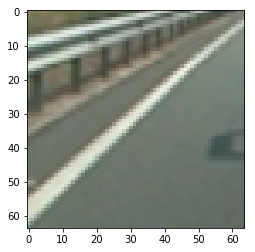

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2

%matplotlib inline

# Load test image filenames
test_images = glob.glob('test_images/test*.jpg')
image = mpimg.imread(test_images[0])
roi_cut_off = int(image.shape[0]/2)
roi_img = image[roi_cut_off:,:,:]

# Load vehicle image locations, make sure to scale to 0-255 int
GTI_MiddleClose = glob.glob('vehicles/vehicles/GTI_MiddleClose/image*.png')
GTI_Far = glob.glob('vehicles/vehicles/GTI_Far/image*.png')
GTI_Left = glob.glob('vehicles/vehicles/GTI_Left/image*.png')
GTI_Right = glob.glob('vehicles/vehicles/GTI_Right/image*.png')
KITTI_extracted = glob.glob('vehicles/vehicles/KITTI_extracted/image*.png')
all_cars = GTI_MiddleClose+GTI_Far+GTI_Left+GTI_Right+KITTI_extracted


# Load non vehicle image locations
not_cars = glob.glob('non-vehicles/non-vehicles/GTI/image*.png')
not_cars_extra = glob.glob('non-vehicles/non-vehicles/Extras/extra*.png')
not_cars = not_cars + not_cars_extra

# Compare data distribution
print("Number of Cars Images:",len(all_cars))
print("Number of Not Car Images",len(not_cars))

# Scales images read as png from 0-1 to 0-255
def scale_png(img):
    img = img * 255
    img = img.astype(int)
    return img

ex_car_img = mpimg.imread(all_cars[0])
ex_not_car_img = mpimg.imread(not_cars[5])
plt.imshow(ex_not_car_img)
plt.savefig('pipeline_images/not_car_example.jpg')

## Feature Functions

(64, 64, 3)


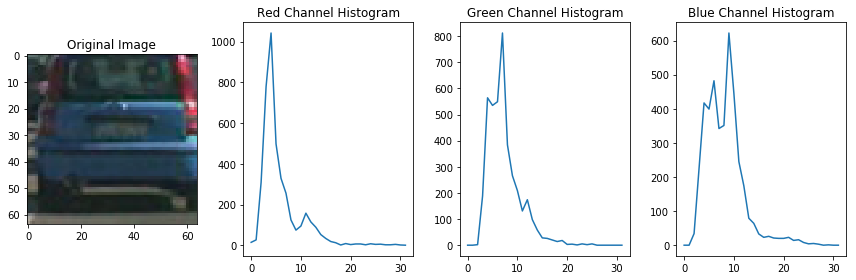

In [2]:
from scipy.misc import imresize
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import time

# Extracts combined features based on a color histogram and spatial bin
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # If imgs is a list of image file names
    if(type(imgs) == list):
        features = []
        for img_name in imgs:
            img = mpimg.imread(img_name)
            if('.png' in img_name):
                img = scale_png(img)
            
            color_histogram = color_hist(img,hist_bins)
            spatial_bin = bin_spatial(img,color_space,spatial_size)
            hog_features = get_hog_features(img[:,:,hog_channel],orient,pix_per_cell,cell_per_block)

            feature = np.concatenate((spatial_bin,color_histogram,hog_features))
            
            features.append(feature)
        return features
        
    # If imgs is a single image
    else:
        img = imgs
        
        #Extract color historgram, spatial bin
        color_histogram = color_hist(img,nbins=hist_bins)
        spatial_bin = bin_spatial(img,color_space,spatial_size)
        hog_features = get_hog_features(img[:,:,hog_channel],orient,pix_per_cell,cell_per_block)

        feature = np.concatenate((spatial_bin,color_histogram,hog_features))

        return feature

# Computes and returns the features based on Histogram Oriented Gradient (HOG)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return hog_features
    
# Computes and returns color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    
    
# Converts image to specified color space and resizes down to use raw pixel values as feature
def bin_spatial(img, color_space='RGB', size=(32, 32),return_image=False):
    # Resize image
    img_small = imresize(img,size)
    
    # Convert to specified color space
    if(color_space == 'HSV'):
        converted_img = cv2.cvtColor(img_small, cv2.COLOR_RGB2HSV)
    elif(color_space == 'LUV'):
        converted_img = cv2.cvtColor(img_small,cv2.COLOR_RGB2LUV)
    elif(color_space == 'RGB'):
        converted_img = img_small
    elif color_space == 'YUV':
        converted_img = cv2.cvtColor(img_small, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        converted_img = cv2.cvtColor(img_small, cv2.COLOR_RGB2YCrCb)
    else:
        print("Invalid color_space")
    
    if(return_image):
        return converted_img
    else:
        spatial_features = converted_img.ravel()
        return spatial_features   


"""
# HOG Image Example
example_feature_img = mpimg.imread(all_cars[0])[:,:,1]
example_feature_img = scale_png(example_feature_img)
hog_features, hog_image = get_hog_features(example_feature_img, 12, 8, 2, 
                        vis=True, feature_vec=True)
#plt.imshow(hog_image)
print(hog_image)
plt.imshow(hog_image,cmap="gray")
plt.savefig('pipeline_images/example_hog.jpg')
"""
"""
# Spatial Binning Example
exampleBinSpatialImg = mpimg.imread(all_cars[0])
spatial_bin = bin_spatial(exampleBinSpatialImg,color_space='RGB',size=(16,16),return_image=True)
print(spatial_bin.shape)
#plt.imshow(spatial_bin[:,:,0],cmap="gray")
plt.imshow(spatial_bin)
plt.savefig('pipeline_images/example_spatial.jpg')
"""

example_hist_img = mpimg.imread(all_cars[0])
new_hist_img = scale_png(example_hist_img)
color_histogram = color_hist(new_hist_img)

print(example_hist_img.shape)
fig = plt.figure(figsize=(12,4))
plt.subplot(141)
plt.imshow(example_hist_img)
plt.title('Original Image')
plt.subplot(142)
plt.plot(color_histogram[0:32])
plt.title('Red Channel Histogram')
plt.subplot(143)
plt.plot(color_histogram[32:64])
plt.title('Green Channel Histogram')
plt.subplot(144)
plt.plot(color_histogram[64:96])
plt.title('Blue Channel Histogram')
fig.tight_layout()
plt.savefig('pipeline_images/histogram_image.jpg')

## Visualize Features Normalization

/home/nickwalton00/anaconda3/envs/gpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


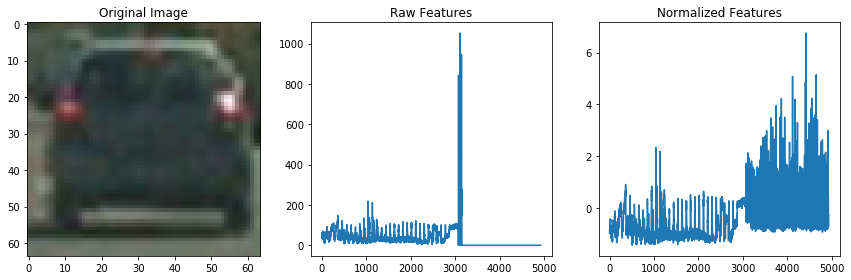

In [3]:
not_car_features = extract_features(not_cars)
car_features = extract_features(all_cars)
X = np.vstack((car_features, not_car_features)).astype(np.float64)           

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

car_ind = np.random.randint(0, len(all_cars))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(all_cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig('pipeline_images/normalization.jpg')

## Classify

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

# Takes in a set of features and labels and returns a trained classifier
def train_svm_classifier(all_cars,not_cars,color_space='RGB', spatial_size=(32, 32),
                         hist_bins=32, orient=9, pix_per_cell=8, 
                         cell_per_block=2,hog_channel=0,optimize=False):
    
    # Extract features from the images
    not_car_features = extract_features(not_cars,color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,hog_channel=hog_channel)
    
    car_features = extract_features(all_cars,color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,hog_channel=hog_channel)
    
    X = np.vstack((car_features, not_car_features)).astype(np.float64)           

    # Normalize the features
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    # Create the labels
    y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(not_car_features))))

    # Split into train and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Train the classifier
    # If optimized then searches in grid for best parameters
    if(optimize):
        parameters = {'kernel':('linear','rbf'), 'C':[0.1,0.1,1]}
        svr = svm.SVC()
        clf = GridSearchCV(svr, parameters)
        clf.fit(X_train, y_train)
        print("Parameters were: ",clf.best_params_)
    else:
        clf = svm.SVC(C=1, kernel='rbf')
        clf.fit(X_train,y_train)
    
    print('Test Accuracy of SVC = %.3f'% clf.score(X_test, y_test))
    
    return clf, X_scaler

# Classifier Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Channel of the image to use with HOG
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

t = time.time()
clf, X_scaler = train_svm_classifier(all_cars, not_cars,color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,hog_channel=hog_channel,optimize=False)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train Classifier')


/home/nickwalton00/anaconda3/envs/gpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Test Accuracy of SVC = 0.995
159.08 Seconds to train Classifier


# Sliding Windows

In [5]:
# Most of the code from this section was provided by Udacity with some modifications made by me

# Function that returns a list of windows in an image based 
# on the start stop positions, the window size and the overlap.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Draws a set of boxes on an image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2,hog_channel=0):
    car_windows = []
    
    #For each window to search
    for window in windows:
        #Extract the window to test from within the window
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract the features for the test img
        features = extract_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block,hog_channel=hog_channel)
        
        # Normalize extracted features using scalar from trained set
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict the label from the features
        prediction = clf.predict(test_features)
        
        #If predicted as a car then save the window
        if prediction == 1:
            car_windows.append(window)
    # Return windows for positive detections
    return car_windows

## Find Vehicles

4.19 Seconds to find and draw windows


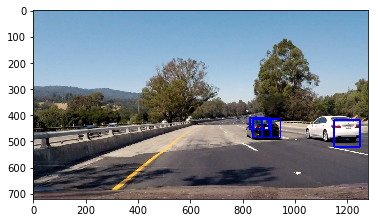

In [15]:


def get_hot_windows(input_img):
    image = input_img
    y_start_stop = [int(image.shape[0]/2), None] # Min and max in y to search in slide_window()
    draw_image = np.copy(image)

    xy_overlap = (0.5,0.5)

    # Create the windows to search

    windows_min = slide_window(image, x_start_stop=[150,1130], y_start_stop=[410,500], 
                        xy_window=(70,45), xy_overlap=(0.75,0.75))
    windows_mid1 = slide_window(image, x_start_stop=[None,None], y_start_stop=[415,520], 
                        xy_window=(70,70), xy_overlap=xy_overlap)
    windows_mid2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[420, 575], 
                        xy_window=(100,100), xy_overlap=xy_overlap)
    windows_mid3 = slide_window(image, x_start_stop=[40, 1280], y_start_stop=[430, 575], 
                        xy_window=(125,125), xy_overlap=xy_overlap)
    windows_mid4 = slide_window(image, x_start_stop=[70, 1280], y_start_stop=[440, 600], 
                        xy_window=(140,140), xy_overlap=xy_overlap)
    windows_max = slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 670], 
                        xy_window=(160,160), xy_overlap=xy_overlap)

    windows = windows_min + windows_mid1 + windows_mid2 + windows_mid3 + windows_mid4 + windows_max

    window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6) 

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)   
    return hot_windows


t = time.time()
image_test = mpimg.imread('test_images/test4.jpg')
hot_windows = get_hot_windows(image_test)
car_img = draw_boxes(image_test, hot_windows, color=(0, 0, 255), thick=6)                    
t2 = time.time()
print(round(t2-t, 2), 'Seconds to find and draw windows')
plt.imshow(car_img)
plt.savefig("pipeline_images/detected_vehicle.jpg")



## Heat Map Detections

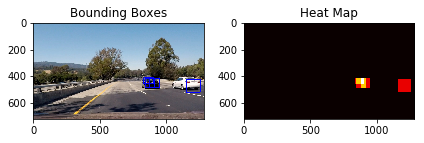

In [17]:
from scipy.ndimage.measurements import label

# Helper functions provided by Udacity
# Function to udpate the heat map within bounding boxes 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Function to threshold heat map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_heatmap_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def detect_vehicles(input_img2, heat_map_vis=False):
    
    input_img = input_img2
    # Get hot window based on classifier
    hot_windows = get_hot_windows(input_img)
    
    heat = np.zeros_like(input_img[:,:,0]).astype(np.float)

    # Add heat to each box in detected list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat_threshold = 0
    heat = apply_threshold(heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw the boxes of the vehicle based on the centroid of the heat clusters
    draw_img = draw_heatmap_bboxes(np.copy(input_img), labels)
    
    if(heat_map_vis):
        return draw_img, heatmap
    else:
        return draw_img


draw_img, heatmap = detect_vehicles(image_test, heat_map_vis = True)

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img)
plt.title('Bounding Boxes')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('pipeline_images/heat_map.jpg')

## Process Video Images

/home/nickwalton00/anaconda3/envs/gpu/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


KeyboardInterrupt: 

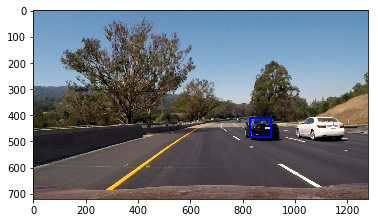

In [8]:
import imageio
from IPython.display import HTML
#Load Video, process each image to find lane and save video output
def process_video(video_file):
    vid = imageio.get_reader(video_file,  'mp4')
    for i, image in enumerate(vid):
        if(i >= 930):
            img = vid.get_data(i)
            output_img = detect_vehicles(img)
            
            if(i < 10):
                zeros = '000'
            elif(i < 100):
                zeros = '00'
            elif(i < 1000):
                zeros='0'
            else:
                zeros=''
                
            save_file_name = "video_images/image"+zeros+str(i)+'.jpg'
            plt.imshow(output_img)
            plt.savefig(save_file_name)
        
video_file = 'project_video.mp4'
%time process_video(video_file)

## Stitch into Video

In [9]:
from moviepy.editor import ImageSequenceClip

clip = ImageSequenceClip('video_images', 20)
clip.write_videofile('output_video.mp4')

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|██████████| 1260/1260 [00:08<00:00, 154.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

